## Анализ данных о чтении и прослушивании контента сервиса Яндекс Книги пользователей из Москвы и Санкт-Петербурга

- Автор: Глотова Виктория
- Дата: 27.05.2025

## Цели и задачи проекта

**Основная цель проекта** - сравнить данные о чтении и прослушивании контента сервиса Яндекс Книги пользователей из Москвы и Санкт-Петербурга и определить, в каком из городов сервис используется активнее.

**Задачи проекта:**
* Загрузить данные и познакомиться с их содержимым;
* Провести предобработку данных, проверив на наличие дубликатов и пропусков;
* Сравнить размеры групп пользователей Москвы и Санкт-Петербурга, их статистики и распределение;
* Проверить гипотезу о том, что пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы.

## Описание данных

Данные предоставлены в двух датасетах. Информация с описанием структуры данных скрыта в соответствии с положением о неразглашении.

## Содержимое проекта

1. Загрузка данных и знакомство с ними.
2. Проверка гипотезы в Python.
3. Аналитическая записка.

---

## 1. Загрузка данных и знакомство с ними

Загрузим библиотеку pandas, а также другие необходимые библиотеки и данные из файла `/datasets/yandex_knigi_data.csv`.

In [6]:
# Импортируем библиотекy pandas
import pandas as pd

# Импортируем другие библиотеки
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.power import NormalIndPower
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

Загрузка данных - информация скрыта в соответствии с положением о неразглашении.

In [8]:
# Выгрузим первые строки полученного датафрейма
knigi.head()

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


In [9]:
# Сделаем столбец Unnamed: 0 индексом
knigi = knigi.set_index('Unnamed: 0')
knigi.head()

,city,puid,hours
Unnamed: 0,,,
0,Москва,9668,26.167776
1,Москва,16598,82.111217
2,Москва,80401,4.656906
3,Москва,140205,1.840556
4,Москва,248755,151.326434


In [10]:
# Получим информацию о типе данных и их количестве
knigi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8784 entries, 0 to 8783
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    8784 non-null   object 
 1   puid    8784 non-null   int64  
 2   hours   8784 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 274.5+ KB


Содержимое датафрейма, включая тип данных, соответствует описанию. Пропусков нет. Проверим наличие дубликатов в данных столбца `puid`.

In [12]:
duplicates = knigi['puid'].duplicated().sum()
duplicates

244

In [13]:
# удалим дубликаты
knigi_cleaned = knigi.drop_duplicates(subset = 'puid')

In [14]:
display(f"Удалено дубликатов: {duplicates}, это {round(duplicates/len(knigi)*100, 2)}% от всех записей")

'Удалено дубликатов: 244, это 2.78% от всех записей'

Убедимся, что в оставшихся данных представлена информация только о пользователях Москвы и Санкт-Петербурга и определим размеры групп.

In [16]:
knigi_cleaned['city'].value_counts()

city
Москва             6234
Санкт-Петербург    2306
Name: count, dtype: int64

Группа пользователей из Москвы значительно больше группы из Санкт-Петербурга. Проверим, являются ли группы независимыми:

In [18]:
moscow_df = knigi_cleaned[knigi_cleaned['city'] == 'Москва'].copy()
spb_df = knigi_cleaned[knigi_cleaned['city'] == 'Санкт-Петербург'].copy()

In [19]:
users_a = set(moscow_df['puid'])
users_b = set(spb_df['puid'])

intersection_group = users_a.intersection(users_b)
display (f'Совпадающих значений между группами Москвы и Санкт-Петербурга: {len(intersection_group)}')

'Совпадающих значений между группами Москвы и Санкт-Петербурга: 0'

Совпадающих значений не обнаружено, группы независимые. Сравним статистики обех групп:

In [21]:
#группа пользователей из Москвы
knigi_cleaned['hours'][knigi_cleaned['city'] == 'Москва'].describe()

count    6234.000000
mean       10.881092
std        36.851683
min         0.000018
25%         0.059903
50%         0.924498
75%         5.939972
max       857.209373
Name: hours, dtype: float64

In [22]:
#группа пользователей из Санкт-Петербурга
knigi_cleaned['hours'][knigi_cleaned['city'] == 'Санкт-Петербург'].describe()

count    2306.000000
mean       11.264433
std        39.831755
min         0.000025
25%         0.060173
50%         0.875355
75%         6.138424
max       978.764775
Name: hours, dtype: float64

Судя по максимальным значения (857 и 978 часов), значению медианы (0.92 и 0.87 часа) и высокому стандартному отклонению (36.85 и 39.83) данные сильно ассиметричны, имеют большие выбросы и не имеют нормального распределения. Построим графики, чтобы в этом убедиться.

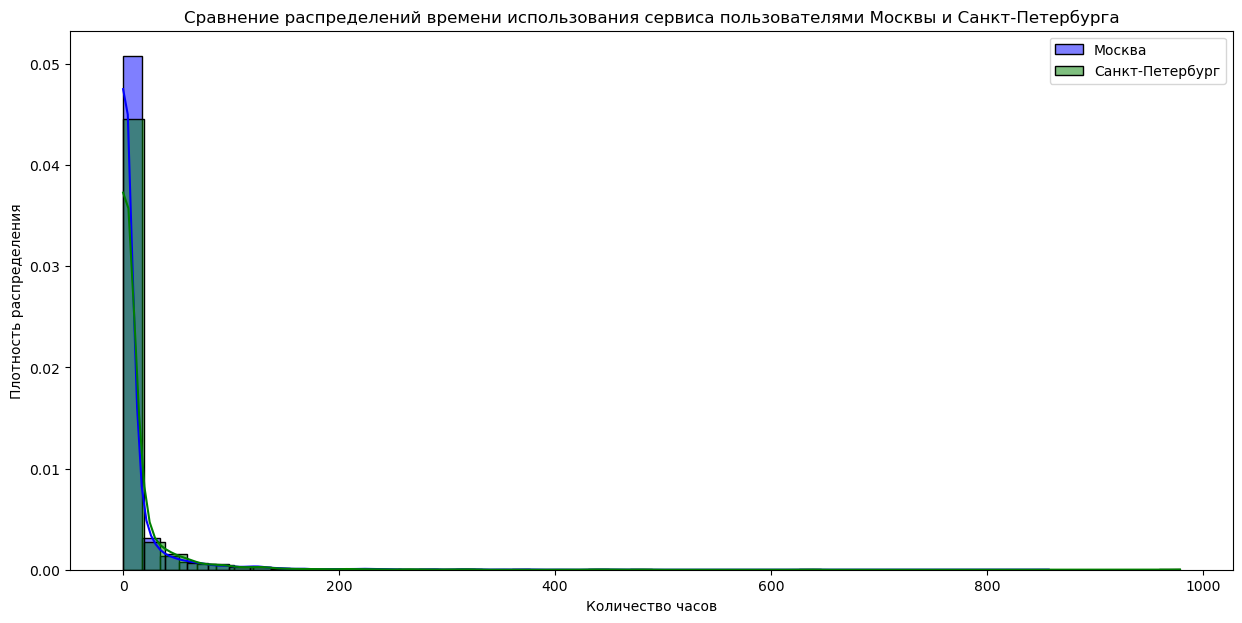

In [24]:
plt.figure(figsize=(15, 7))
sns.histplot(moscow_df['hours'], color='blue', label='Москва', kde=True, stat='density', bins=50, alpha=0.5)
sns.histplot(spb_df['hours'], color='green', label='Санкт-Петербург', kde=True, stat='density', bins=50, alpha=0.5)

plt.legend()
plt.xlabel('Количество часов')
plt.ylabel('Плотность распределения')
plt.title('Сравнение распределений времени использования сервиса пользователями Москвы и Санкт-Петербурга')
plt.show()

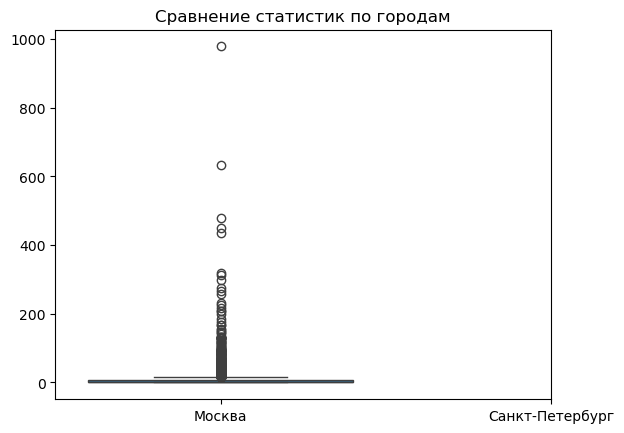

In [25]:
sns.boxplot(data=[moscow_df['hours'], spb_df['hours']])
plt.xticks([0, 1], ['Москва', 'Санкт-Петербург'])
plt.title('Сравнение статистик по городам')
plt.show()

Таким образом, в ходе знакомства с данными выявлено следующее:
- из исходного датафрейма удалено 244 дубликата по идентификационному номеру пользователя, это 2.78% от всех записей;
- оставшиеся данные поделены на 2 группы по городам пользователей, проверены на независимость, пересечений между пользователями нет;
- группы неравномерны по количеству пользователей, их распределения по столбцу `hours` ассиметричны и имеют большие выбросы, следовательно, это необходимо учесть при проверке гипотезы.

## 2. Проверка гипотезы в Python

Гипотеза: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Проверим ее, используя одностороннюю проверку гипотезы с двумя выборками:

Нулевая гипотеза H₀: Средняя активность пользователей в часах в Санкт-Петербурге не больше, чем в Москве.

Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

С учетом того, что мы имеем разные по размеру группы, в которых наблюдаются выборосы и асимметрия и отсутсвует нормальное распределение в исследуемой метрике, используем тест Манна-Уитни, чтобы проверить различаются ли выборочные распределения. Он более устойчив к выбросам, чем t-тест и в данном контексте будет являться более надежным инструментом для проверки.

In [30]:
from scipy.stats import mannwhitneyu

alpha = 0.05
mw_test = mannwhitneyu(
    spb_df['hours'],
    moscow_df['hours'],  
    alternative='greater') #пользователи из Санкт-Петербурга проводят в среднем больше времени в приложении, чем пользователи из Москвы

In [31]:
if mw_test.pvalue > alpha:
    print(f'pvalue={mw_test.pvalue} > {alpha}')
    print('Нулевая гипотеза находит подтверждение.')
    print('Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.')
else:
    print(f'pvalue={mw_test.pvalue} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения.')
    print('Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо')

pvalue=0.6189600878052618 > 0.05
Нулевая гипотеза находит подтверждение.
Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.


## 3. Аналитическая записка

**Общие выводы по итогам проведенного исследования:**

* Для проверки гипотезы использовался тест Манна-Уитни, так как количество пользователей в группах сильно различается, и нормальное распределение в исследуемой метрике отсутствует. Уровень статистической значимости установлен = 0.05.
* В результате теста установлено, что p-value = 0.6189600878052618, это больше, чем уровень статистической значимости 0.05. Следовательно, гипотеза о том, что средняя активность пользователей в Санкт-Петербурге больше, чем в Москве, не подтвердилась. Результаты показали, что средняя активность пользователей в часах, проведенных в приложении за чтением или прослушиванием контента, в двух группах не различается.
* Полученные результаты могут объясняться тем, что Санкт-Петербург и Москва - два больших города, со схожим ритмом жизни пользователей. Поэтому и количество часов, которые они в среднем тратят на чтение, примерно одинаково или имеет незначительные различия, которые не являются статистически значимыми. Кроме того, у нас нет информации о каких-либо маркетинговых акциях, проводимых в одном из городов, которые могли бы увеличить время, проведенное в приложении. Следовательно, пользователи находились в равных условиях доступа к контенту, что и подтвердилось исследованием.


----

# Часть 2. Анализ результатов A/B-тестирования

## 2.1. Цели и задачи проведенного исследования.

**Основная цель исследования** - провести оценку результатов A/B-теста `interface_eu_test` и подтвердить или опровергнуть гипотезу.

**Гипотеза:** пользователи сайта с обновленным интерфейсом чаще совершают покупки в первые 7 дней после регистрации, чем пользователи сайта без обновлений.

* Нулевая гипотеза H₀: Количество пользователей сайта со старым интерфейсом  и количество пользователей новой версии сайта, совершивших покупку в первые 7 дней после регистрации, не различается.

* Альтернативная гипотеза H₁: Количество пользователей новой версии сайта, совершивших покупку в первые 7 дней после регистрации, больше, чем количество купивших пользователей на сайте со старым интерфейсом, конверсия зарегистрированных пользователей в покупателей увеличится как минимум на 3%.

**Задачи:**
- Загрузить данные, познакомиться с ними;
- Оценить корректность проведения эксперимента (достаточность групп, непересечение участников);
- Провести оценку результатов тестирования.

**Описание данных.**

Информация скрыта в соответствии с положением о неразглашении.


## 2.2 Загрузка данных и оценка их целостности.

Загрузка данных в два датафрейма - информация скрыта в соответствии с положением о неразглашении.

In [40]:
participants.head()

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


In [41]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


Данные о пользователях содержат 1425 строк и 4 столбца. Пропусков в столбцах нет. Проверим датасет на дубликаты:

In [43]:
participants.duplicated().sum()

0

Полных дубликатов нет, убедимся в уникальности Id пользователей.

In [45]:
participants['user_id'].duplicated().sum()

887

Дубликаты присутствуют, однако это может быть связано с тем, что один и тот же пользователь мог участвовать в разных тестах. Поэтому пока оставим их без обработки.

In [47]:
events.head()

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


In [48]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


In [49]:
 dupl = events.duplicated().sum()

In [50]:
share_dupl = dupl / len(events) * 100
display(f"Доля дубликатов в датафрейме evens {round(share_dupl, 2)}%")

'Доля дубликатов в датафрейме evens 4.61%'

Очистим датафрейм от дубликатов

In [52]:
events = events.drop_duplicates()
display(f"Удалено дубликатов: {dupl}, это {round(share_dupl, 2)}% от всех записей")

'Удалено дубликатов: 36318, это 4.61% от всех записей'

Данные о событиях содержат 787286 строк и 4 столбца. Присутствуют пропуски в столбце `details`, однако это не должно помешать исследованию, обработка пропусков не требуется. Датафрейм проверен на полные дубликаты, удалено 36318 строк (4.61%). 

Объединим 2 таблицы в одну для удобства дальнейшей работы с результатами теста.

In [54]:
df = events.merge(participants, on = 'user_id',how = 'left')
df.head()

,user_id,event_dt,event_name,details,group,ab_test,device
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15,NaN,NaN,NaN
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0,NaN,NaN,NaN
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN,NaN,NaN,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN,NaN,NaN,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN,NaN,NaN,NaN


Таблицы объединены, можно перейти к анализу результатов проведенного тестироования.

## 2.3 Оценка корректности проведения теста (по таблице `ab_test_participants`):

Создадим новый датафрейм, который будет содержать только информацию о тесте `interface_eu_test`.

In [58]:
df_test = df[(df['ab_test'] == 'interface_eu_test')].copy()

len(df_test)

73545

Выделим 2 группы и проверим количество уникальных пользователей в них.

In [60]:
df_test_a = df_test[(df_test['group'] == 'A')]
df_test_b = df_test[(df_test['group'] == 'B')]

a_unique = df_test_a['user_id'].nunique()
b_unique = df_test_b['user_id'].nunique()

P = 100 * abs(a_unique - b_unique)/a_unique

display(f'Количество уникальных пользователей в группе А = {a_unique}, в группе В = {b_unique}. Разница = {abs(a_unique - b_unique)}.')
display(f"Рассчитанная процентная разница в количестве пользователей в группах A и B равна {round(P, 3)}%")

'Количество уникальных пользователей в группе А = 5383, в группе В = 5467. Разница = 84.'

'Рассчитанная процентная разница в количестве пользователей в группах A и B равна 1.56%'

Количество уникальных пользователей в группах различается на 1.56%, что не критично для теста. Проверим независимость групп.

In [62]:
a_users = set(df_test_a['user_id'])
b_users = set(df_test_b['user_id'])

intersect_group = a_users.intersection(b_users)
display (f'Совпадающих значений между группами A и В: {len(intersect_group)}')

'Совпадающих значений между группами A и В: 0'

Группы независимы, пересечений между пользователями нет. 

Вернемся к датафрейму `df` и проверим, нет ли пересечений пользователей в группе В с конкурирующим тестом.

In [65]:
# выделим в отдельный датафрейм информацию о других тестах и отфильтруем пользователей группы В
df_others = df[(df['ab_test'] != 'interface_eu_test')].copy()
other_users_b = df_others[(df_others['group'] == 'B')]

In [66]:
# проверим, есть ли пересечения между пользователями разных тестов в группе В
b_users_other = set(other_users_b['user_id'])

intersect_group_2 = b_users_other.intersection(b_users)
display (f'Совпадающих значений между тестовыми группами двух тестов: {len(intersect_group_2)}')

'Совпадающих значений между тестовыми группами двух тестов: 116'

In [67]:
# убедимся, что пересечений этих пользователей с группой А нет
intersect_group_3 = b_users_other.intersection(a_users)
display (f'Совпадающих значений с группой А: {len(intersect_group_3)}')

'Совпадающих значений с группой А: 106'

В ходе проверки пересечений с конкурирующим тестом обнаружено 116 пользователей, которые одновременно принимали участие в тестовых группах двух тестов и 106 пользователей из тестовой группы конкурирующего теста, которые принимали участие в контрольной группе. Необходимо очистить датафрейм от данных пользователей, которые пересекаются в тестовых группах.

In [69]:
# удалим пользователей, которые участовали в других тестах в тестовых группах
df_test_cleaned = df_test[~((df_test['user_id'].isin(intersect_group_2)) & (df_test['group'] == 'B'))].copy()
display(f"Удалено строк из-за пересечений тестовых групп: {len(df_test) - len(df_test_cleaned)}")

'Удалено строк из-за пересечений тестовых групп: 610'

In [70]:
df_test_b2 = df_test_cleaned[(df_test_cleaned['group'] == 'B')]
b_unique_2 = df_test_b2['user_id'].nunique()

perc = 100 * abs(a_unique - b_unique_2)/a_unique

display(f'Количество уникальных пользователей в группе В = {b_unique_2}. Разница c группой А = {abs(a_unique - b_unique_2)}.')
display(f"Рассчитанная процентная разница в количестве пользователей в группах A и B равна {round(perc, 3)}%")

'Количество уникальных пользователей в группе В = 5351. Разница c группой А = 32.'

'Рассчитанная процентная разница в количестве пользователей в группах A и B равна 0.594%'

Данные пользователей, которые попали в тестовые группы двух тестов удалены. Теперь тестовая группа составляет 5351 человек и различается с контрольной на 32 человека (0.59%).

Проверим равномерность распределения пользователей по устройствам.

In [73]:
df_test_cleaned['device'].unique()

array(['iPhone', 'Android', 'PC', 'Mac'], dtype=object)

device
Android    2445
Mac         566
PC         1346
iPhone     1026
Name: user_id, dtype: int64

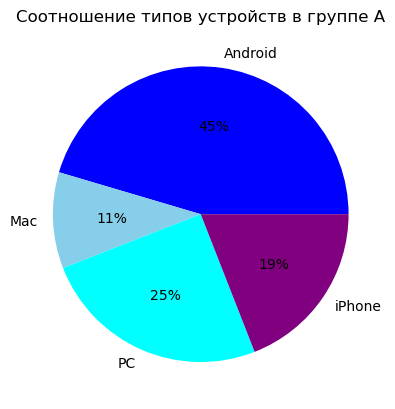

In [74]:
#рассчитаем количество разных типов устройств в группе А по уникальным пользователям
unique_users_a = df_test_a[['user_id', 'device']].drop_duplicates()
device_group_a = unique_users_a.groupby('device')['user_id'].count()
display(device_group_a)

#построим круговую даиграмму для группы А
device_group_a.plot(
    kind= 'pie',
    title='Соотношение типов устройств в группе А',
    autopct='%.0f%%',
    ylabel= '',
    colors= ['blue','skyblue','cyan','purple'])

plt.show()

Сделаем аналогичные расчеты по группе В.

device
Android    2363
Mac         545
PC         1391
iPhone     1052
Name: user_id, dtype: int64

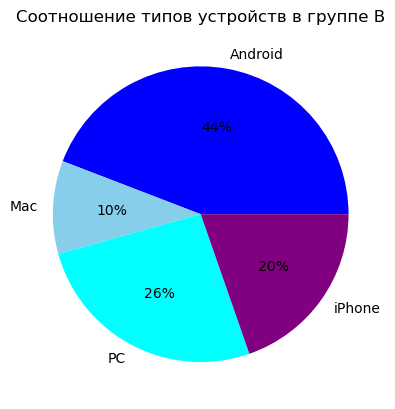

In [76]:
df_test_b2 = df_test_cleaned[(df_test_cleaned['group'] == 'B')]

#рассчитаем количество разных типов устройств в группе В по уникальным пользователям
unique_users_b = df_test_b2[['user_id', 'device']].drop_duplicates()
device_group_b = unique_users_b.groupby('device')['user_id'].count()
display(device_group_b)

#построим круговую даиграмму для группы В
device_group_b.plot(
    kind= 'pie',
    title='Соотношение типов устройств в группе В',
    autopct='%.0f%%',
    ylabel= '',
    colors= ['blue','skyblue','cyan','purple'])

plt.show()

Соотношение типов устройств в группах примерно одинаковое, различия в пределах 1%.

Судя по имеющимся данным, группы равномерно распределены и являются независимыми, что говорит о корректности проведенного теста..

Проверим, какие события содержит датафрейм с данными о тестировании.

In [79]:
df_test_cleaned['event_name'].unique()

array(['registration', 'login', 'product_page', 'purchase',
       'product_cart'], dtype=object)

Добавим в датафрейм столбцы с датой события датой регистрации и расчетом количества дней с момента регистрации до момента события.

In [81]:
# добавим столбец с датой события
df_test_cleaned['date'] = pd.to_datetime(df_test_cleaned['event_dt']).dt.date

# выделим датафрейм с датами регистрации (первая регистрация)
reg_df = df_test_cleaned[df_test_cleaned['event_name'] == 'registration'].copy()
reg_df = reg_df.groupby('user_id', as_index=False)['date'].min().rename(columns = {'date': 'reg_date'})

In [82]:
reg_df.head()

,user_id,reg_date
0,0002CE61FF2C4011,2020-12-07
1,001064FEAAB631A1,2020-12-20
2,001E72F50D1C48FA,2020-12-17
3,002412F1EB3F6E38,2020-12-09
4,002540BE89C930FB,2020-12-08


In [83]:
df_test_cleaned.head()

,user_id,event_dt,event_name,details,group,ab_test,device,date
64143,5F506CEBEDC05D30,2020-12-06 14:10:01,registration,0.0,A,interface_eu_test,iPhone,2020-12-06
64414,51278A006E918D97,2020-12-06 14:37:25,registration,-3.8,A,interface_eu_test,Android,2020-12-06
66047,A0C1E8EFAD874D8B,2020-12-06 17:20:22,registration,-3.32,B,interface_eu_test,iPhone,2020-12-06
67326,275A8D6254ACF530,2020-12-06 19:36:54,registration,-0.48,A,interface_eu_test,iPhone,2020-12-06
67382,0B704EB2DC7FCA4B,2020-12-06 19:42:20,registration,0.0,B,interface_eu_test,PC,2020-12-06


In [84]:
# присоединим дату регистрации к основному датафрейму и найдем количество дней со дня регистрации до события
df_test_cleaned['date'] = pd.to_datetime(df_test_cleaned['date'], errors='coerce')
df_test_cleaned = df_test_cleaned.merge(reg_df, on = 'user_id',how = 'left')
df_test_cleaned['reg_date'] = pd.to_datetime(df_test_cleaned['reg_date'], errors='coerce')
df_test_cleaned['days_since_reg'] = (df_test_cleaned['date'] - df_test_cleaned['reg_date']).dt.days
# проверяем
df_test_cleaned.head()

,user_id,event_dt,event_name,details,group,ab_test,device,date,reg_date,days_since_reg
0,5F506CEBEDC05D30,2020-12-06 14:10:01,registration,0.0,A,interface_eu_test,iPhone,2020-12-06,2020-12-06,0
1,51278A006E918D97,2020-12-06 14:37:25,registration,-3.8,A,interface_eu_test,Android,2020-12-06,2020-12-06,0
2,A0C1E8EFAD874D8B,2020-12-06 17:20:22,registration,-3.32,B,interface_eu_test,iPhone,2020-12-06,2020-12-06,0
3,275A8D6254ACF530,2020-12-06 19:36:54,registration,-0.48,A,interface_eu_test,iPhone,2020-12-06,2020-12-06,0
4,0B704EB2DC7FCA4B,2020-12-06 19:42:20,registration,0.0,B,interface_eu_test,PC,2020-12-06,2020-12-06,0


Оставим в таблице только события, совершенные в первые 7 дней после регистрации.

In [86]:
df_test_cleaned = df_test_cleaned[df_test_cleaned['days_since_reg'] < 7].copy()

Оставим в таблице данные только по 2 событиям - регистрация и покупка. Посчитаем количество зарегистрированных пользователей в каждой группе и количество пользователей, совершивших покупку в первые 7 дней после регистрации.

In [88]:
df_reg_pur = df_test_cleaned[df_test_cleaned['event_name'].isin(['registration', 'purchase'])].copy()
purchase_df = df_reg_pur[df_reg_pur['event_name'] == 'purchase']
registr_df = df_reg_pur[df_reg_pur['event_name'] == 'registration']

In [89]:
# посчитаем общее количество регистраций по группам и уникальное количество пользователей, купивших в первые 7 дней
buyers = purchase_df.groupby('group')['user_id'].nunique().reset_index()
buyers = buyers.rename(columns = {'user_id': 'count_buyers'})
reg_users = registr_df.groupby('group')['user_id'].nunique().reset_index()
reg_users = reg_users.rename(columns = {'user_id': 'reg_users'})

# объединим данные в единую таблицу и рассчитаем долю купивших от зарегистрированных
df_test_groups = reg_users.merge(buyers, on = 'group')
df_test_groups['share'] = round(df_test_groups['count_buyers'] / df_test_groups['reg_users'], 3)
display(df_test_groups)

,group,reg_users,count_buyers,share
0,A,5383,1448,0.269
1,B,5351,1533,0.286


Рассчитаем необходимый размеры выборки для каждой группы и сравним с тем, что получилось у нас. Базовый показатель конверсии - 30%, по нашей гипотезе нас будет интересовать увеличение конверсии минимум на 3 процентных пункта, т.е. mde = 0.03. Мощность теста - 80%, соответственно ошибка 2 рода = 1-0.8. Достоверность теста - 95%, соответственно alpha = 0.05.

In [91]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода
p = 0.3 # Базовый показатель конверсии
power = 0.8  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = abs(2 *  (np.arcsin(np.sqrt(p)) - np.arcsin(np.sqrt(p + mde)))),
    power = power,
    alpha = alpha,
    ratio = 1, # Равномерное распределение выборок
    alternative='larger'
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 2963


Расчетный размер выборки для каждой группы меньше, чем количество пользователей в обеих группах. Следовательно, имеющихся в результате исследований данных достаточно для выявления статистически значимого эффекта.

Вернемся к нашей таблице `df_test_groups` и зафиксируем видимые изменения в конверсии обеих групп. Для этого сохраним значения конверсии в переменных:

In [94]:
conv_a = df_test_groups[df_test_groups['group'] == 'A']['share'].values[0]
conv_b = df_test_groups[df_test_groups['group'] == 'B']['share'].values[0]

In [95]:
# Рассчитаем разницу между конверсией групп А и В
abs_diff = 100 * abs(conv_a - conv_b)
percent_diff = 100 * abs(conv_a - conv_b)/conv_a

print(f"Конверсии зарегистрированных пользователей в покупателей в двух группах различаются на {round(abs_diff, 3)} п.п.. Рассчитанная процентная разница равна {round(percent_diff, 3)}%")

Конверсии зарегистрированных пользователей в покупателей в двух группах различаются на 1.7 п.п.. Рассчитанная процентная разница равна 6.32%


Предварительно видно, что конверсия в группе с обновленным интерфейсом сайта выше, чем в группе, которая пользовалась старой версией сайта, однако эта разница ниже ожидаемой (3 п.п.). Проведем необходимые статистические расчеты, чтобы в этом убедиться.

## 4. Оценка результатов A/B-тестирования:

Используем Z-тест пропорций для проверки гипотезы.

**Гипотеза:** пользователи сайта с обновленным интерфейсом чаще совершают покупки в первые 7 дней после регистрации, чем пользователи сайта без обновлений.

* Нулевая гипотеза H₀: Конверсия зарегистрированных пользователей в покупателей в течение первых 7 дней в тестовой группе (В) не выше 3 п.п., чем в группе А.

* Альтернативная гипотеза H₁: Конверсия зарегистрированных пользователей в покупателей в течение первых 7 дней в тестовой группе (В) выше, чем в группе А, разница составляет как минимум 3 процентных пункта.


In [99]:
# зафиксируем в переменных число зарегистрированных пользователей
reg_a = reg_users[reg_users['group'] == 'A']['reg_users'].values[0]
reg_b = reg_users[reg_users['group'] == 'B']['reg_users'].values[0]

In [100]:
# зафиксируем в переменных число пользователей, совершивших покупку в первые 7 дней
buyers_a = buyers[buyers['group'] == 'A']['count_buyers'].values[0]
buyers_b = buyers[buyers['group'] == 'B']['count_buyers'].values[0]

In [101]:
n_b, n_a = reg_b, reg_a # берём значения по размерам выборок A и B 
m_b, m_a = buyers_b, buyers_a # берём значения по количеству успехов в выборках A и B 

alpha = 0.05 #устанавливаем достоверность теста

stat_ztest, p_value_ztest = proportions_ztest(
    [m_b, m_a],
    [n_b, n_a],
    value = 0.03,
    alternative = 'larger' # так как H_1: (p_b - p_a)>0.03
)

In [102]:
p_value_ztest

if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение. Конверсия зарегистрированных пользователей в покупателей в группе В не больше, чем в группе А.')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения! Конверсия зарегистрированных пользователей в покупателей в экспериментальной группе выше, чем в контрольной.')

pvalue=0.9259866960180975 > 0.05
Нулевая гипотеза находит подтверждение. Конверсия зарегистрированных пользователей в покупателей в группе В не больше, чем в группе А.


**Общие выводы по итогам эксперимента:**

* Цель эксперимента - выяснить, будет ли новый интерфейс сайта положительно влиять на пользователей и увеличит конверсию зарегистрированных пользователей в покупателей в первые 7 дней после регистрации как минимум на 3 процентных пункта.
* Ключевая метрика - доля пользователей, совершивших покупку в первые 7 дней после регистрации.
* Количество уникальных пользователей, принявших участие в эксперименте - 5351 в тестовой группе (В) и 5383 в контрольной (А). Минимально допустимое количество пользователей в каждой группе - 2963.
* Доля пользователей, совершивших покупку в первые 7 дней после регистрации в экспериментальной группе равна 0.284, в контрольной - 0.269, что на 5.576% меньше, чем в экспериментальной. Однако, прирост конверсии составил всего 1.7 процентных пункта и не достиг ожидаемых 3 пунктов.
* Для проверки результатов А/В тестирования был использован Z-тест пропорций. Значение p-value = 0.9259866960180975, что больше уровня значимости 0.05. Это говорит о том, что подтвердилась нулевая гипотеза: конверсия зарегистрированных пользователей в покупателей в течение первых 7 дней в тестовой группе (В) не выше 3 п.п., чем в группе А. Следовательно, новый интерфейс сайта не повлиял ожидаемым образом на конверсию пользователей, ее прирост ниже того, на который рассчитывали, и нет необходимости на данном этапе внедрять новый интерфейс на всех пользователей. Следует продумать иные шаги для увеличения конверсии, и, возможно, сделать дополнительные доработки сайта.
